In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

In [2]:
def analysis_data(data):
#     data = data[['utr', 'utr_originial_varylength', 'label', 'y_pred', 'y_true']]
#     data['y_true'] = data['label']
#     data['y_pred'] = data['y_pred']
    data['diff'] = abs(data.y_true - data.y_pred)
    data.sort_values('diff', ascending = True, inplace = True)
    data['diff_rank'] = range(1, data.shape[0]+1)
    data.sort_values('y_pred', ascending = False, inplace = True)
    data['pred_rank'] = range(1, data.shape[0]+1)
    data.sort_values('y_true', ascending = False, inplace = True)
    data['true_rank'] = range(1, data.shape[0]+1)
    print(f'data.shape = {data.shape}')
    return data

def analysis_rank(data, cutoff = 10, print_ = False):   
    pred_n = sum(data.iloc[:cutoff].pred_rank <= cutoff)
    diff_n = sum(data.iloc[:cutoff].diff_rank <= cutoff)
    pred_r = pred_n/cutoff
    diff_r = diff_n/cutoff
#     print(f'From samples with Cut-Off={cutoff} Top Labels (y_true): \n(1) {pred_n} samples are in top {cutoff} Ranked y_pred \n(2) {diff_n} samples are in top {cutoff} Ranked diff=|y_pred-label|')
    if print_: print(f'From {len(data)} samples with CutOff={cutoff} Top Labels: The ratios (1) Diff_rank={diff_n}/{cutoff}={diff_n/cutoff:.2f} (2) Pred_rank={pred_n}/{cutoff}={pred_n/cutoff:.2f} ')
    return pred_n, diff_n, pred_r, diff_r

def multi_cutoffs_analysis(data, cutoffs, print_ = False):
    top_pred_n, top_diff_n, top_pred_r, top_diff_r = [], [], [], []
    for cutoff in cutoffs:
        np, nd, rp, rd = analysis_rank(data, cutoff, print_)
        top_pred_n.append(np)
        top_diff_n.append(nd)
        top_pred_r.append(rp)
        top_diff_r.append(rd)
    data_analysis = pd.DataFrame([cutoffs, top_pred_n, top_pred_r, top_diff_n, top_diff_r], 
                    index = ['Cut-Off', '# Top Pred in Cut-Off', 'Ratio: Top Pred in Cut-Off', 
                             '# Top Diff in Cut-Off', 'Ratio: Top Diff in Cut-Off']).T
    data_analysis['# Samples'] = len(data)
    data_analysis[['# Samples', 'Cut-Off', '# Top Pred in Cut-Off', '# Top Diff in Cut-Off']] = data_analysis[['# Samples', 'Cut-Off', '# Top Pred in Cut-Off', '# Top Diff in Cut-Off']].astype('int')
    data_analysis[['Ratio: Top Pred in Cut-Off', 'Ratio: Top Diff in Cut-Off']] = data_analysis[['Ratio: Top Pred in Cut-Off', 'Ratio: Top Diff in Cut-Off']].round(2)
    return data_analysis
import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr
def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2
def performances(label, pred):
    
    r = r2(label, pred)
    pearson_r = pearsonr(label, pred)[0]
    sp_cor = spearmanr(label, pred)[0]
    
    print(f'r-squared = {r:.4f} | pearson r = {pearson_r:.4f} | spearman R = {sp_cor:.4f}')
        
    return [r, pearson_r, sp_cor]

def classify_number(num):
    if num <= 0 or num > 100:
        return "Number out of range"
    elif num <= 25:
        return "(0, 25]"
    elif num <= 50:
        return "(25, 50]"
    elif num <= 75:
        return "(50, 75]"
    else:
        return "(75, 100]"
def generate_cutoffs(n):
    nl = []
    if n > 5: nl += list(range(5, [n,51][n>50], 5))
    if n > 50: nl += list(range(50, [n, 101][n>100], 10))
    if n > 100: nl += list(range(100, [n, 1001][n>1000], 50))
    if n > 1000: nl += list(range(1000, [n, 10001][n>10000], 100))
    nl += [n]
    return nl

In [3]:
import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr
def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

def performances(label, pred):
    
    r = r2(label, pred)
    pearson_r = pearsonr(label, pred)[0]
    sp_cor = spearmanr(label, pred)[0]
    
    print(f'r-squared = {r:.4f} | pearson r = {pearson_r:.4f} | spearman R = {sp_cor:.4f}')
        
    return [r, pearson_r, sp_cor]


In [4]:
def load_proposed_results(metrics_df, ypred_files, save_ = False):
    pwd = './revised_results/'
    results_df = pd.DataFrame()
    for i, f in enumerate(ypred_files):
        if i == 0:
            results_df = pd.read_csv(pwd + f)
            outfile = pwd + '_'.join(f.split('_')[:-2])#replace('_val_fold0', '')
            print(outfile)
        else:
            temp = pd.read_csv(pwd + f)
            results_df = pd.concat([results_df, temp], axis = 0)
    
    results_df = analysis_data(results_df)
    cutoffs = list(range(1, len(results_df)+1, 1))#list(range(5, 50, 5)) + list(range(50, 212, 10)) 
    ranking = multi_cutoffs_analysis(results_df, cutoffs, False)
    if save_: 
        results_df.to_csv(outfile + 'Ypred.csv')
        ranking.to_csv(outfile + '_Ranking.csv')
    return results_df, ranking

# benchmark

In [5]:
hek = pd.read_csv('HEK_sequence.csv')
pc3 = pd.read_csv('pc3_sequence.csv')
muscle = pd.read_csv('Muscle_sequence.csv')
cao_te_log = pd.concat([muscle, pc3, hek], axis = 0).te_log

sample_mrl = pd.read_csv('/home/ubuntu/human_5utr_modeling-master/data/4.1_train_data_GSM3130435_egfp_unmod_1.csv').rl
len(cao_te_log), len(sample_mrl)

(28246, 260000)

In [6]:
optimus_results = pd.read_csv('./revised_results/Experimental_data_Retrained_Optimus_MRL_results.csv')
optimus_ranking_results = pd.read_csv('./revised_results/Experimental_data_Retrained_Optimus_MRL_ranking_results.csv')
optimus_metrics = pd.read_csv('./revised_results/Experimental_data_Retrained_Optimus_MRL_metrics.csv', index_col = 0)
optimus_metrics

,Test_R,Test_PearsonR,Test_SpearmanR
0,0.018950,-0.137658,-0.219395
1,0.003035,0.055093,0.084498
2,0.063803,-0.252593,-0.214054
3,0.010502,0.102479,0.093282
4,0.000268,0.016382,0.240410
5,0.002674,-0.051710,-0.287668
6,0.031294,-0.176900,-0.279025
7,0.038100,-0.195193,-0.158803
8,0.003899,-0.062440,-0.108760
9,0.014763,-0.121501,-0.054001


# proposed

In [7]:
utrlm_metrics = pd.read_csv('./revised_results/UTRLM_finetuned_results.csv', index_col = 0)[['Test_R2', 'Test_PearsonR', 'Test_SpearmanR']]
utrlm_metrics

,Test_R2,Test_PearsonR,Test_SpearmanR
0,0.004336,-0.065845,0.219333
1,0.341736,0.584581,0.614737
2,0.226212,0.475618,0.402733
3,0.235990,0.485788,0.414309
4,0.219389,0.468390,0.453630
5,0.106554,0.326427,0.328341
6,0.167768,0.409595,0.375492
7,0.141469,0.376123,0.545458
8,0.032345,0.179846,0.332779
9,0.309792,0.556590,0.472692


In [8]:
utrlm_res = pd.DataFrame()
for i in range(10):
    utrlm_res = pd.concat([utrlm_res, pd.read_csv(f'./revised_results/UTRLM_finetuned_val_fold{i}.csv')],
                          axis = 0)
utrlm_res.reset_index(drop = True)
utrlm_res

,utr_50,y_true,y_pred,Unnamed: 0,rvac_ID,utr_originial_varylength,label,old_label,utr_100,Length
0,AGAGGAGTCGAGTTATACAGCCGCAACGCTATCCTCGACGAACACA...,1.02,1.030635,35,RV-UML-m085,AGAGGAGTCGAGTTATACAGCCGCAACGCTATCCTCGACGAACACA...,1.02,1.02,<pad><pad><pad><pad><pad><pad><pad><pad><pad><...,50
1,AGGAAATTCAGGAAGAATTTTCCTCCTCTACAGAACTCGTCTGGTC...,1.14,1.023675,101,RV-UML-m281,AGGAAATTCAGGAAGAATTTTCCTCCTCTACAGAACTCGTCTGGTC...,1.14,1.14,<pad><pad><pad><pad><pad><pad><pad><pad><pad><...,50
2,AGCAAACGTAGGGGGATACTGCGCGTCCATAAAATCCTCTCAACGT...,0.98,1.040552,53,RV-UML-m073,AGCAAACGTAGGGGGATACTGCGCGTCCATAAAATCCTCTCAACGT...,0.98,0.98,<pad><pad><pad><pad><pad><pad><pad><pad><pad><...,50
3,AGAGTTCGTACAGACCAAGTTCATTTCAATCACGGGATACGAGCTG...,0.99,1.028911,42,RV-UML-m320,AGAGTTCGTACAGACCAAGTTCATTTCAATCACGGGATACGAGCTG...,0.99,0.99,<pad><pad><pad><pad><pad><pad><pad><pad><pad><...,50
4,AGGTTTTGGGGACGCAAAGAGAAAACGCTTGAGTCACTCTTAGAGT...,0.68,1.024014,153,RV-UML-m092,AGGTTTTGGGGACGCAAAGAGAAAACGCTTGAGTCACTCTTAGAGT...,0.68,1.11,<pad><pad><pad><pad><pad><pad><pad><pad><pad><...,50
...,...,...,...,...,...,...,...,...,...,...
16,AGTCGAGGGGCTTATTCTGCGTTTCTGCACGAGCGAATTCTGACGG...,1.16,0.522976,167,RV-UML-m279,AGTCGAGGGGCTTATTCTGCGTTTCTGCACGAGCGAATTCTGACGG...,1.16,1.16,<pad><pad><pad><pad><pad><pad><pad><pad><pad><...,50
17,AGCTTAAGTGTTTCCGCTATTCTTGTTGTCTGCTTTACTTGACGGG...,1.12,1.088778,92,RV-UML-m288,AGCTTAAGTGTTTCCGCTATTCTTGTTGTCTGCTTTACTTGACGGG...,1.12,1.12,<pad><pad><pad><pad><pad><pad><pad><pad><pad><...,50
18,AGTTATTTGCGATAAACAGTAGGGAGACAATTGACCTGCACAGCGT...,1.24,1.084612,189,RV-UML-m302,AGTTATTTGCGATAAACAGTAGGGAGACAATTGACCTGCACAGCGT...,1.24,1.24,<pad><pad><pad><pad><pad><pad><pad><pad><pad><...,50
19,AGGTTGGCGGAAGTGCTCCCGCGTCTACACTCTCAAGTCGTCACCG...,1.05,-1.168233,151,RV-UML-m364,AGGTTGGCGGAAGTGCTCCCGCGTCTACACTCTCAAGTCGTCACCG...,1.05,1.05,<pad><pad><pad><pad><pad><pad><pad><pad><pad><...,50


In [9]:
f_ = [f'UTRLM_finetuned_val_fold{i}.csv' for i in range(10)]
utrlm_results = load_proposed_results(utrlm_res, f_, save_ = True)
utrlm_results

./revised_results/UTRLM_finetuned
data.shape = (211, 14)


(                                               utr_50  y_true    y_pred  \
 9   AGGTCCGTTATATTATTTATCTTGCAGATCAAACTTCAGAGAGGAG...    1.33  1.045338   
 16  AGGGAACAGTGGAGCACAATAGTTGTCACAAACGCGTGACCTGTAC...    1.31  1.068428   
 14  AGAGAAAGAGTTTCGAGAAAGTTGCGATACACACCGACCTAATCCG...    1.26  1.045425   
 11  AGTGGAGAGCGCAATCCAGTTTCCTTAGCAAAGCATATCACCCTTC...    1.24  0.435014   
 18  AGTTATTTGCGATAAACAGTAGGGAGACAATTGACCTGCACAGCGT...    1.24  1.084612   
 ..                                                ...     ...       ...   
 7   AGTTTCGTTCACTGTCCTTGACTAGAGAATATAATAAAAAGATTGT...    0.52  1.007977   
 19  AGCGTTTCTATTTTCGCAGTTTCGGATCTGCCTTTTCGCGGATTTA...    0.52  1.256208   
 1   AGCCAGTTTCGCTTGGCTCAACCAGCCCATATACAAAGACCCCGAC...    0.51  1.065283   
 16  AGTTCGCTTTGTTATTCTTGCCAGTTTGTAGTTACCTAAAACCCAT...    0.49  0.943369   
 16  AGTTTGGAACGAGGGGAAAATACTTGTTTCGAGCGATCGCGGGGGA...    0.48  1.026749   
 
     Unnamed: 0      rvac_ID  \
 9          144  RV-UML-m002   
 16         127  RV-UM

# plot

In [10]:
def smooth(x, y):
    X_Y_Spline = make_interp_spline(x, y)

    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    return X_, Y_

import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from scipy.interpolate import make_interp_spline

import matplotlib.ticker as mticker

def smoothing_KR(x, y, alpha=0.99, kernel="rbf"):
    x = np.array(x)
    y = np.array(y)
    
    clf = KernelRidge(alpha=alpha, kernel=kernel)
    clf.fit(x.reshape(-1, 1), y)
    y_2 = clf.predict(x.reshape(-1, 1))
    return y_2
def plot_ranking_esm2_benchmark(ax,
                                temp_esm2, 
                                temp_benm, benchm_mrl_f,
                                esm_mrl_spearman, benchmark_mrl_spearman,
                                metric = 'Pred', topk = int(211/2),
                                smoothing = False):
    ratio = True
    metric = f'Ratio: Top {metric} in Cut-Off'

#     temp_esm2 = label_ranking_pushLen_dict[mrl_f].drop_duplicates()
#     temp_benm = benchmark_ranking_results[benchm_mrl_f].drop_duplicates()
    n = int(temp_esm2.iloc[-1]['# Samples'])

    temp_esm2_auc_all = np.trapz(temp_esm2[metric])
    temp_benm_auc_all = np.trapz(temp_benm[metric])

    temp_esm2 = temp_esm2[temp_esm2['Cut-Off'] <= topk]
    temp_benm = temp_benm[temp_benm['Cut-Off'] <= topk]
    temp_esm2_auc_topk = np.trapz(temp_esm2[metric])
    temp_benm_auc_topk = np.trapz(temp_benm[metric])
    
    if smoothing:
        temp_esm2_smoothY = smoothing_KR(temp_esm2['Cut-Off']/n, temp_esm2[f'{metric}']) * 100
        temp_benm_smoothY = smoothing_KR(temp_benm['Cut-Off']/n, temp_benm[f'{metric}']) * 100
    else:
        temp_esm2_smoothY = temp_esm2[f'{metric}'] * 100
        temp_benm_smoothY = temp_benm[f'{metric}'] * 100
        
    ax.plot(temp_esm2['Cut-Off']/n*100, 
        temp_esm2_smoothY, 
        color = 'red', 
        label = f"ESM2|AUC_50%={temp_esm2_auc_topk:.2f}|AUC_all={temp_esm2_auc_all:.2f}|Spearman={esm_mrl_spearman:.4f}")

    ax.plot(temp_benm['Cut-Off']/n*100, 
             temp_benm_smoothY, 
             '--', color = 'red', 
             label = f"Benchmark|AUC_50%={temp_benm_auc_topk:.2f}|AUC_all={temp_benm_auc_all:.2f}|Spearman={benchmark_mrl_spearman:.4f}")
    
    ax.plot(temp_esm2['Cut-Off']/n*100, 
            temp_esm2['Cut-Off']/n*100, 
            ':', color = 'black', 
            label = 'y=x')
    
    ax.set_xlabel('Top True Rank %', size = 15)
    ax.set_ylabel('Top Overlap_Pred Rank %', size = 15)
    ax.set_title(f'Finetuned: RVAC | n = {n} | {metric} Rank', size = 15)
    ax.legend(fontsize = 10, loc = 'lower right')

    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))
    ax.set_xticks(range(0,51,5))

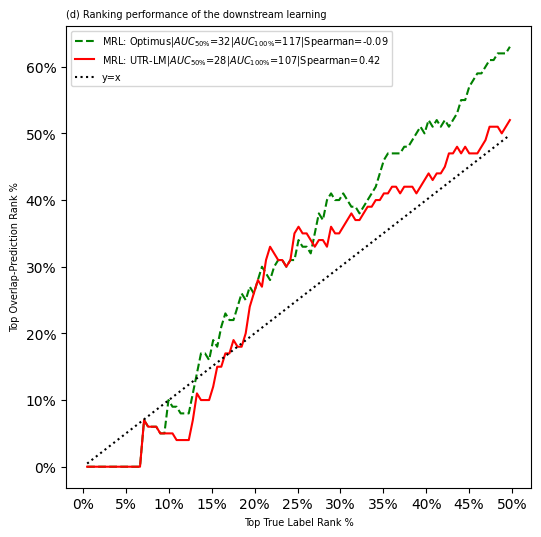

In [11]:
utrlm_spearman = utrlm_metrics.loc["mean", "Test_SpearmanR"]
benm_spearman = optimus_metrics.loc["mean", "Test_SpearmanR"]
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))

ratio = True
metric = 'Pred'
topk = int(211/2)
smoothing = False
metric = f'Ratio: Top {metric} in Cut-Off'

temp_esm2 = utrlm_results[-1]
temp_benm = optimus_ranking_results

n = int(temp_esm2.iloc[-1]['# Samples'])

temp_esm2_auc_all = np.trapz(temp_esm2[metric])
temp_benm_auc_all = np.trapz(temp_benm[metric])

temp_esm2 = temp_esm2[temp_esm2['Cut-Off'] <= topk]
temp_benm = temp_benm[temp_benm['Cut-Off'] <= topk]
temp_esm2_auc_topk = np.trapz(temp_esm2[metric])
temp_benm_auc_topk = np.trapz(temp_benm[metric])

if smoothing:
    temp_esm2_smoothY = smoothing_KR(temp_esm2['Cut-Off']/n, temp_esm2[f'{metric}']) * 100
    temp_benm_smoothY = smoothing_KR(temp_benm['Cut-Off']/n, temp_benm[f'{metric}']) * 100
else:
    temp_esm2_smoothY = temp_esm2[f'{metric}'] * 100
    temp_benm_smoothY = temp_benm[f'{metric}'] * 100

ax.plot(temp_benm['Cut-Off']/n*100, 
         temp_benm_smoothY, 
         '--', color = 'green', 
         label = "MRL: Optimus|${AUC_{50\%}}$=" + f"{temp_benm_auc_topk:.0f}|" + "${AUC_{100\%}}$=" + f"{temp_benm_auc_all:.0f}|Spearman={benm_spearman:.2f}")

ax.plot(temp_esm2['Cut-Off']/n*100, 
    temp_esm2_smoothY, 
    color = 'red', 
    label = "MRL: UTR-LM|${AUC_{50\%}}$=" + f"{temp_esm2_auc_topk:.0f}|" + "${AUC_{100\%}}$=" + f"{temp_esm2_auc_all:.0f}|Spearman={utrlm_spearman:.2f}")

ax.plot(temp_esm2['Cut-Off']/n*100, 
        temp_esm2['Cut-Off']/n*100, 
        ':', color = 'black', 
        label = 'y=x')

ax.set_xlabel('Top True Label Rank %', size = 7)
ax.set_ylabel('Top Overlap-Prediction Rank %', size = 7)
ax.legend(fontsize = 7, loc = 'upper left')
ax.set_title(f'(d) Ranking performance of the downstream learning', size = 7, loc = 'left')

ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))
ax.set_xticks(range(0,51,5))
plt.savefig('./revised_results/subfigureD_ranking_performance_retrained.svg')
plt.show()